# Remote Robot Edition
In this exercise we are going to go through the basics of remote controlling a liquid handler robot - OpenTrons OT-2

Useful Links:
- [API Documentation](https://docs.opentrons.com/v2/index.html)
- [Protocol Library](https://protocols.opentrons.com/)

Log: 
- 20220816 after temperature module change

In [1]:
# First, we load the OpenTrons library and call home
# Re-run this cell will reset the protocol!
from opentrons import protocol_api

metadata = {
    'protocolName': 'My Protocol',
    'author': 'Weiting <weitinglin66@gmail.com>',
    'description':'Simple protocol to get started using OT2',
    'apiLevl': '2.5'
}
        

In [2]:
import opentrons.execute
protocol = opentrons.execute.get_protocol_api('2.5')

Failed to initialize character device, will not be able to control gpios (lights, button, smoothiekill, smoothie reset). Only one connection can be made to the gpios at a time. If you need to control gpios, first stop the robot server with systemctl stop opentrons-robot-server. Until you restart the server with systemctl start opentrons-robot-server, you will be unable to control the robot using the Opentrons app.


# Load labware and pipete
Labware are the physical components mounted on the OpenTrons deck. Labware can include tips, wells, racks, etc.
We can see which labware is already part of the OpenTrons Labware Library.

p300:20 ul - 300 ul
p20: 1 - 20 uL

the labware we had:
## Reservour
1. NEST 96 Well Plate 100 uL: nest_96_wellplate_100ul_pcr_ful_skirt
2. Opentrons 24 Tube Rack with NEST 1.5 ml Snapcap: opentrons_24_tuberack_nest_1.5ml_snapcap
## Tips
3. Opentrons 96 Tips Rack 300 ul: opentrons_96_tiprack_300ul
4. Opentrons 96 Tips Rack 10 ul: opentrons_96_10ul


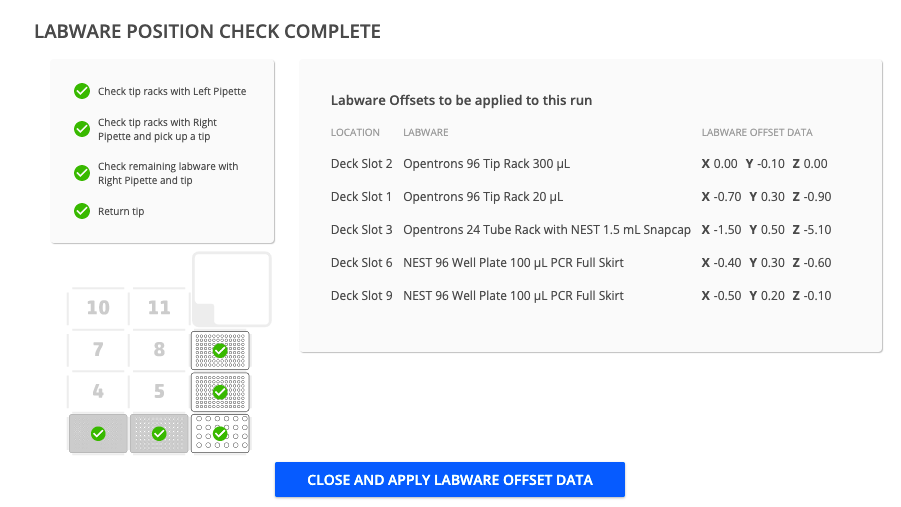



In [3]:
# Define the labware

# ==== Tips
tips_300 = protocol.load_labware('opentrons_96_tiprack_300ul',
                                 '2',
                                 'Opentrons Tips')
    


tips_20 = protocol.load_labware('opentrons_96_tiprack_20ul',
                                '1',
                                'Opentrons Tips')

# ==== Reservoir

LInput_container = protocol.load_labware('opentrons_24_tuberack_nest_1.5ml_snapcap',
                                     '3',
                                     'Reagent')

Input_container = protocol.load_labware('nest_96_wellplate_100ul_pcr_full_skirt',
                                         '6',
                                        'Primer and DNA Source')

Output_container = protocol.load_labware('nest_96_wellplate_100ul_pcr_full_skirt',
                                         '9',
                                         'Mixture Endproduct')

#primers_screwcap = protocol.load_labware('opentrons_24_tuberack_nest_2ml_screwcap',
#                                             '5',
#                                             'Primer Source')

# ==== PCR mixture
#tc_mod = protocol.load_module('Thermocycler Module')
    
#PCR_plate = tc_mod.load_labware('nest_96_wellplate_100ul_pcr_full_skirt')

# ==== Magnetic Module

#mag_mod = protocol.load_module('magnetic module gen2', '3')
    
    

#mag_plate = mag_mod.load_labware('nest_96_wellplate_100ul_pcr_full_skirt',
#                               label='magnetic extraction')
# ==== Pipette


left_pipette = protocol.load_instrument('p300_single',
                                              'left',
                                              tip_racks=[tips_300])

right_pipette = protocol.load_instrument('p20_single_gen2',
                                              'right',
                                              tip_racks=[tips_20])

# Adjust the Position for accuracy fluid handling

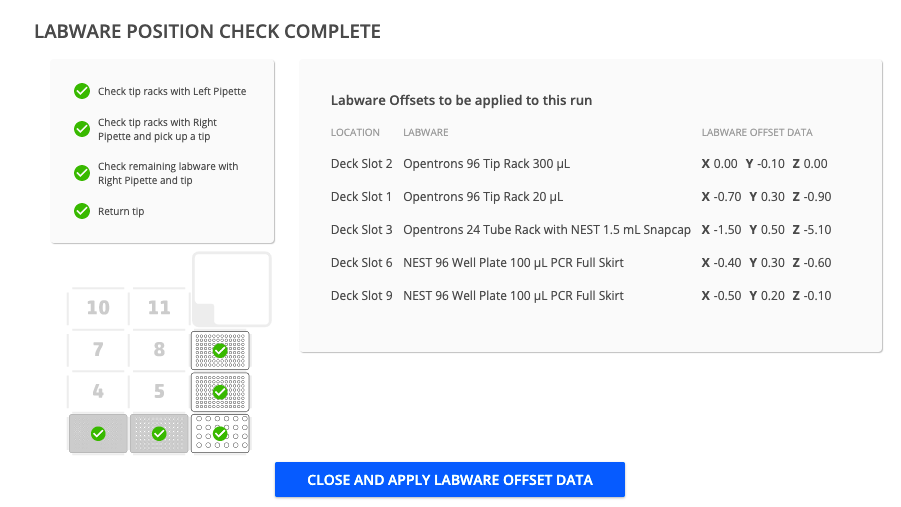

In [4]:
# Position Calibration with the data gathered from GUI workflow information
# Perfect!! we can use the GUI workflow for calibration, then take the parameter in the jupyter
# Tips

    
tips_300.set_offset(0,-0.1,0) # Slot 2

tips_20.set_offset(-0.7,0.3,-0.9)  # Slot 1


# Reservoir
LInput_container.set_offset(-1.5, 0.5, -5.1)      # Slot 3

Input_container.set_offset(-0.4, 0.3, -0.6)       # Slot 6

Output_container.set_offset(-0.5, 0.2, -0.1)      # Slot 9

# PCR_plate.set_offset(-1.9, 0, -0.7)             # Thermocycle Module Slot
    
# Magnetic Module
    

#mag_plate.set_offset(-0.5,1.4,-0.9)

In [5]:
protocol.home()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0
Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


# Setup and Test Module SetOff

In [15]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300['A1'])
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹
left_pipette.aspirate(100, LInput_container['A1'])
left_pipette.dispense(100, Output_container['A1'])
left_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


<InstrumentContext: p300_single_v2.1 in LEFT>

In [16]:
right_pipette.flow_rate.aspirate = 2
right_pipette.flow_rate.dispense = 3

right_pipette.pick_up_tip(tips_20['A1'])
right_pipette.well_bottom_clearance.dispense = 1  # 這高度就算可以惹
right_pipette.aspirate(7, Output_container['A1'])
right_pipette.dispense(7, Input_container['A1'])
right_pipette.drop_tip()

<InstrumentContext: p20_single_v2.1 in RIGHT>

# Input the Layout information CSV
- single primers mixed as barcode paired to 16 tubes
- log: 
- 20220610: add 13 arc-aro, 14 aro-glp, 15 pta-tpi
- 20220622: use 16 to 24 combination
- 20220630: use 24 combination for PCR preparation
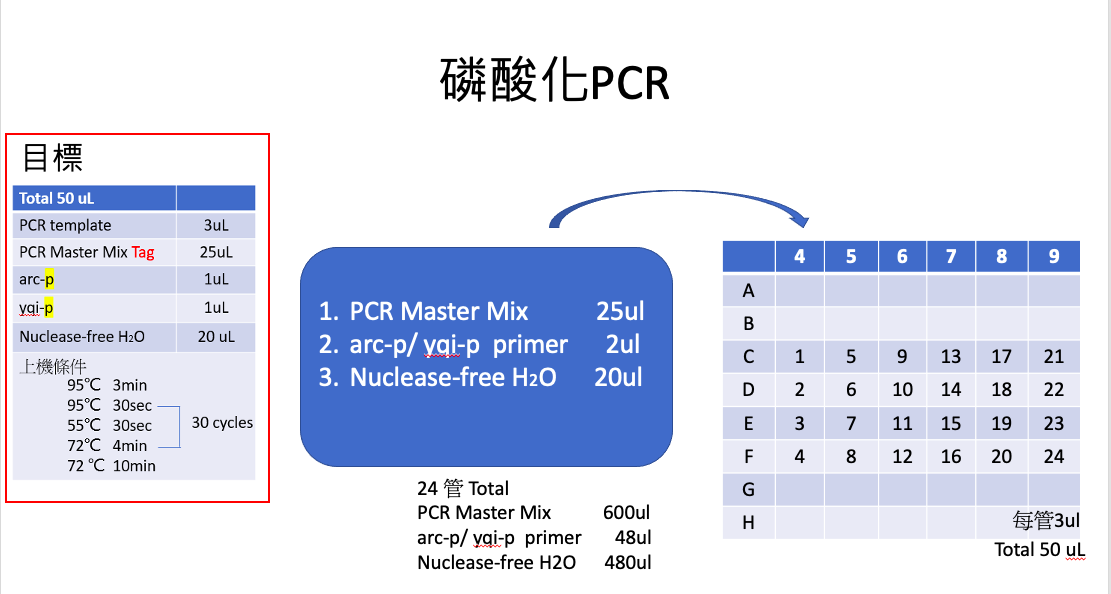


In [14]:
# primer location in 96-well: mapping primer to its physical well position
#Opentron 操作細節
#https://support.opentrons.com/s/article/Connecting-to-your-OT-2-with-SSH
#https://support.opentrons.com/s/article/Setting-up-SSH-access-to-your-OT-2
# use the code to import plate mapping information into the python3
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220723_16tube_position.csv root@169.254.199.65:/root/script
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220723_24_endproductLayout_set3.csv root@169.254.199.65:/root/script
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220723_barcode108_set3.csv root@169.254.199.65:/root/script
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key  20220723_DNAtoPosition.csv root@169.254.199.65:/root/script

import csv
import string


input_24_combination_layout={}        
with open('/root/script/20220815_16_endproductLayout_setv1.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                input_24_combination_layout.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1

output_24_combination_layout={}        
with open('/root/script/20220815_16new_endproductLayout_v1.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                output_24_combination_layout.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1

{'11': 'C3'}
{'13': 'D3'}
{'15': 'E3'}
{'25': 'F3'}
{'31': 'C4'}
{'35': 'D4'}
{'36': 'E4'}
{'37': 'F4'}
{'38': 'C6'}
{'39': 'D6'}
{'40': 'E6'}
{'41': 'F6'}
{'42': 'C7'}
{'43': 'D7'}
{'44': 'E7'}
{'45': 'F7'}
{'11': 'C7'}
{'13': 'D7'}
{'15': 'E7'}
{'25': 'F7'}
{'31': 'C8'}
{'35': 'D8'}
{'36': 'E8'}
{'37': 'F8'}
{'38': 'C9'}
{'39': 'D9'}
{'40': 'E9'}
{'41': 'F9'}
{'42': 'C10'}
{'43': 'D10'}
{'44': 'E10'}
{'45': 'F10'}


In [26]:
output_24_combination_layout

{'11': 'C7',
 '13': 'D7',
 '15': 'E7',
 '25': 'F7',
 '31': 'C8',
 '35': 'D8',
 '36': 'E8',
 '37': 'F8',
 '38': 'C9',
 '39': 'D9',
 '40': 'E9',
 '41': 'F9',
 '42': 'C10',
 '43': 'D10',
 '44': 'E10',
 '45': 'F10'}

# Overall Workflow Design
- step 1 : put the large volume to each 24 position(A1 -> 36.5 uL): use 300ul tips
- step 2 : put primer into the each 24 position (input 96-> 24, each 2 ul)
- step 3 : put DNA into each 24 position (input 1.5 each)


In [29]:
tip_num = []
for num in list(range(1,13)):
    for pos in list(range(1,9)):
        tmp_pos = f"{string.ascii_uppercase[pos-1]}{num}"
        tip_num.append(tmp_pos)

In [30]:
iter_tips = iter(tip_num)

In [31]:
iter_20_tips = iter(tip_num)

In [28]:
list(range(1, 9))

[1, 2, 3, 4, 5, 6, 7, 8]

# Step 1
## move  mixture to each 24 position (each 47 ul)

In [32]:
####### Opentrion description##############
#
# make 24 tubes with mixture 
#
###########################################
# 20220728 golden gate reagent 
####### Set up machine pipette parameter
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

# ===================== use 24 tips ================== 1

#'11', '13', '15', '25', '31', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'
target_number = [11, 13, 15, 25, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
iter_target = iter(target_number)

# pick tips once
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
# tips change module
for time in list(range(1,3)):
    left_pipette.aspirate(186, LInput_container['A1'])
    
    for number in list(range(1, 9)):

        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.well_bottom_clearance.dispense = 1
        left_pipette.dispense(23, Output_container[disperse_position])
        
left_pipette.drop_tip() 

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


<InstrumentContext: p300_single_v2.1 in LEFT>

# Step 2
## put DNA  into 24 position (each 3 ul)

In [33]:
####### Opentrion description ===
#  put the primer according to barcode deisng, seperate into two steps due to tips
#
#  Position ONE
###########################################
####### Set up machine pipette parameter
right_pipette.flow_rate.aspirate = 3  # speed too quick
right_pipette.flow_rate.dispense = 3
right_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 



# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well
target_number = [11, 13, 15, 25, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

for item_set in target_number:
    print("set item: ",item_set,"test")
    
    input_position = input_24_combination_layout[f"{item_set}"]  
    destination = output_24_combination_layout[f"{item_set}"]    
    print(destination)
    
    right_pipette.pick_up_tip(tips_20[next(iter_20_tips)])
    right_pipette.aspirate(2, Input_container[input_position])
    right_pipette.dispense(2, Output_container[destination])
    right_pipette.blow_out()    
    right_pipette.drop_tip()

set item:  11 test
C7
set item:  13 test
D7
set item:  15 test
E7
set item:  25 test
F7
set item:  31 test
C8
set item:  35 test
D8
set item:  36 test
E8
set item:  37 test
F8
set item:  38 test
C9
set item:  39 test
D9
set item:  40 test
E9
set item:  41 test
F9
set item:  42 test
C10
set item:  43 test
D10
set item:  44 test
E10
set item:  45 test
F10


In [136]:
tmp_barcode24_combination = barcode24_combination[16][4:7]


In [138]:
list(range(16, 17))

[16]

In [140]:
for item_set in list(range(16, 17)):
    print("set item: ",item_set,"test")
    print(tmp_barcode24_combination)
    for primer in tmp_barcode24_combination:
        primer_locate = inputPlate_position[primer]
        destination = output_24_combination_layout[f"{item_set}"]
        print(primer_locate)
        print(destination)
        right_pipette.pick_up_tip()
        right_pipette.aspirate(2, Input_container[primer_locate])
        right_pipette.dispense(2, Output_container[destination])
        right_pipette.blow_out()    
        right_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


set item:  16 test
['15', '12']
E3
F7
G3
F7


### Please change the tips rack here "**************************************"

In [146]:
####### Opentrion description ===
#  put the primer according to barcode deisng, seperate into two steps due to tips
#
#  Position TWO
###########################################
for item_set in list(range(17, 25)):
    print("set item: ",item_set,"test")
    print(barcode24_combination[item_set])
    for primer in barcode24_combination[item_set]:
        primer_locate = inputPlate_position[primer]
        destination = output_24_combination_layout[f"{item_set}"]
        print(primer_locate)
        print(destination)
        right_pipette.pick_up_tip()
        right_pipette.aspirate(2, Input_container[primer_locate])
        right_pipette.dispense(2, Output_container[destination])
        right_pipette.blow_out()    
        right_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


set item:  17 test
['2', '4', '5', '7', '9', '12']
B1
C8
E1
C8
G1
C8
A3
C8
C3
C8
G3
C8
set item:  18 test
['2', '4', '5', '7', '10', '12']
B1
D8
E1
D8
G1
D8
A3
D8
D3
D8
G3
D8
set item:  19 test
['2', '4', '5', '7', '15', '11']
B1
E8
E1
E8
G1
E8
A3
E8
E3
E8
F3
E8
set item:  20 test
['2', '4', '5', '7', '15', '12']
B1
F8
E1
F8
G1
F8
A3
F8
E3
F8
G3
F8
set item:  21 test
['2', '14', '5', '7', '9', '11']
B1
C9
F1
C9
G1
C9
A3
C9
C3
C9
F3
C9
set item:  22 test
['2', '14', '5', '7', '9', '12']
B1
D9
F1
D9
G1
D9
A3
D9
C3
D9
G3
D9
set item:  23 test
['2', '14', '5', '7', '10', '11']
B1
E9
F1
E9
G1
E9
A3
E9
D3
E9
F3
E9
set item:  24 test
['2', '14', '5', '7', '10', '12']
B1
F9
F1
F9
G1
F9
A3
F9
D3
F9
G3
F9


# Step 3
## put DNA into the 24 mixture and mix (echo 1.5 ul)

In [ ]:
####### Opentrion description ===
#  
#  put the DNA to each position
#  
###########################################
####### Set up machine pipette parameter
#right_pipette.flow_rate.aspirate = 1.5  # speed too quick
#right_pipette.flow_rate.dispense = 1.5
#right_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 



# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well

for item_set in list(range(2, 25)):
    print("set item: ",item_set,"test")
    print(DNAtobarcode[item_set])
    DNAst=DNAtobarcode[item_set]
    DNA_locate = inputPlate_position[DNAst]
    destination = output_24_combination_layout[f"{item_set}"]
    print(DNA_locate)
    print(destination)    
    right_pipette.pick_up_tip()
    right_pipette.well_bottom_clearance.dispense = 1
    right_pipette.well_bottom_clearance.aspirate = 1
    right_pipette.aspirate(1.5, Input_container[DNA_locate])
    right_pipette.dispense(1.5, Output_container[destination])
    right_pipette.well_bottom_clearance.dispense = 2
    right_pipette.well_bottom_clearance.aspirate = 2
    right_pipette.flow_rate.dispense = 3
    right_pipette.aspirate(10, Output_container[destination])
    right_pipette.dispense(10, Output_container[destination])
    right_pipette.flow_rate.dispense = 1.5
    right_pipette.flow_rate.aspirate = 1.5
    right_pipette.well_bottom_clearance.dispense = 1
    right_pipette.well_bottom_clearance.aspirate = 1
    right_pipette.blow_out()    
    right_pipette.drop_tip()
    
    # 3 test: C7-> E4 weird
    # 4 test: C7-> E4 weird

set item:  2 test
ST7
B8
D4
set item:  3 test
ST59
C7
E4
set item:  4 test
ST15
D8
F4
set item:  5 test
ST1232
E7
C5
set item:  6 test
ST97
F8
D5
set item:  7 test
ST1
G7
E5
set item:  8 test
ST789
H8
F5
set item:  9 test
ST239
A7
C6
set item:  10 test
ST7
B8
D6
set item:  11 test
ST59
C7
E6
set item:  12 test
ST15
D8
F6
set item:  13 test
ST1232
E7
C7
set item:  14 test
ST97
F8
D7
set item:  15 test
ST1
G7
E7
set item:  16 test
ST789
H8
F7
set item:  17 test
ST239
A7
C8
set item:  18 test
ST7
B8
D8
set item:  19 test
ST59
C7
E8
set item:  20 test
ST15
D8
F8
set item:  21 test
ST1232
E7
C9
set item:  22 test
ST97
F8
D9
set item:  23 test
ST1
G7
E9


# Thermocycler PCR reagent
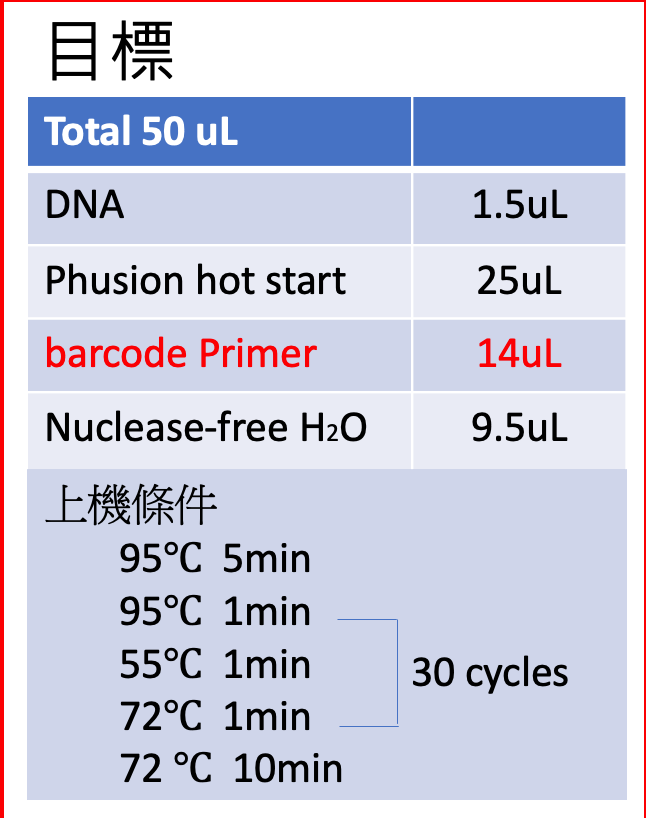

# Position Design Part: original primer position
- log: 20220610
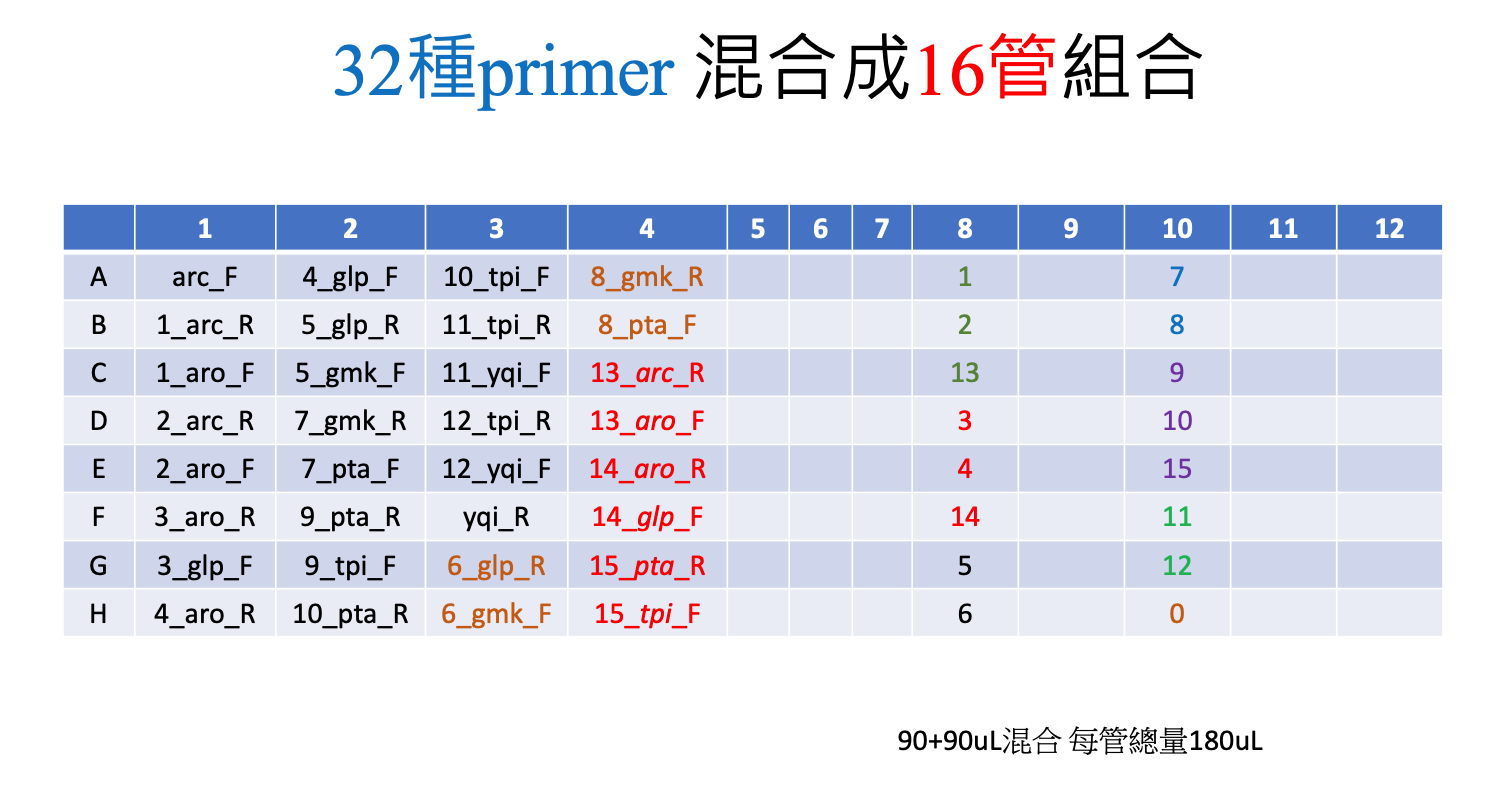

# Import plat position information from CSV

In [90]:
# primer location in 96-well: mapping primer to its physical well position
#Opentron 操作細節
#https://support.opentrons.com/s/article/Connecting-to-your-OT-2-with-SSH
https://support.opentrons.com/s/article/Setting-up-SSH-access-to-your-OT-2
# use the code to import plate mapping information into the python3
# scp -i ot2_ssh_key  20220611_96plate_layout.csv root@169.254.199.65:/root/script
import csv
import string
primer_location_list = {}
with open('/root/script/20220611_96plate_layout.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for primer in row:
            position = f"{string.ascii_uppercase[j]}{i}"
            tmp ={primer:position}
            #print(tmp)
            primer_location_list.update(tmp)
            j=j+1
        i=i+1
        
barcode_tube_mixture = {}
with open('/root/script/20220611_96plate_endproduct.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                barcode_tube_mixture.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1
        



In [83]:
barcode_tube_mixture

{'1': 'A8',
 '2': 'B8',
 '13': 'C8',
 '3': 'D8',
 '4': 'E8',
 '14': 'F8',
 '5': 'G8',
 '6': 'H8',
 '7': 'A10',
 '8': 'B10',
 '9': 'C10',
 '10': 'D10',
 '15': 'E10',
 '11': 'F10',
 '12': 'G10',
 '0': 'H10'}

In [82]:
primer_barcode_dict[mixture_keys[5]]

['14_aro_R', '14_glp_F']

# Opentron: mix 16 tubes of barcodes mixture

In [91]:
####### Opentrion description
# make 16 tubes with mixture primers
#
#
###########################################
####### Set up machine pipette parameter
#left_pipette.flow_rate.aspirate = 15  # speed too quick
#left_pipette.flow_rate.dispense = 15
#left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

# get the barcode tube mixture keys
mixture_keys   = list(barcode_tube_mixture.keys())
mixutre_values = list(barcode_tube_mixture.values())

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well
for item_set in barcode_tube_mixture:
    print("set item: ",item_set,"test")
    for primer in primer_barcode_dict[item_set]:
        primer_locate = primer_location_list[primer]
        destination = barcode_tube_mixture[item_set]
        print(primer_locate)
        print(destination)
        
        #left_pipette.pick_up_tip()
        #left_pipette.aspirate(25, primers_container[primer_locate])
        #left_pipette.dispense(25, primers_container[destination])
        #left_pipette.blow_out()    
        #left_pipette.drop_tip()

set item:  1 test
B1
A8
C1
A8
set item:  2 test
D1
B8
E1
B8
set item:  13 test
C4
C8
D4
C8
set item:  3 test
F1
D8
G1
D8
set item:  4 test
H1
E8
A2
E8
set item:  14 test
E4
F8
F4
F8
set item:  5 test
B2
G8
C2
G8
set item:  6 test
G3
H8
H3
H8
set item:  7 test
D2
A10
E2
A10
set item:  8 test
A4
B10
B4
B10
set item:  9 test
F2
C10
G2
C10
set item:  10 test
H2
D10
A3
D10
set item:  15 test
G4
E10
H4
E10
set item:  11 test
B3
F10
C3
F10
set item:  12 test
D3
G10
E3
G10
set item:  0 test
A1
H10
F3
H10


# Position Design Part: mixed tubes
- log: 20220610
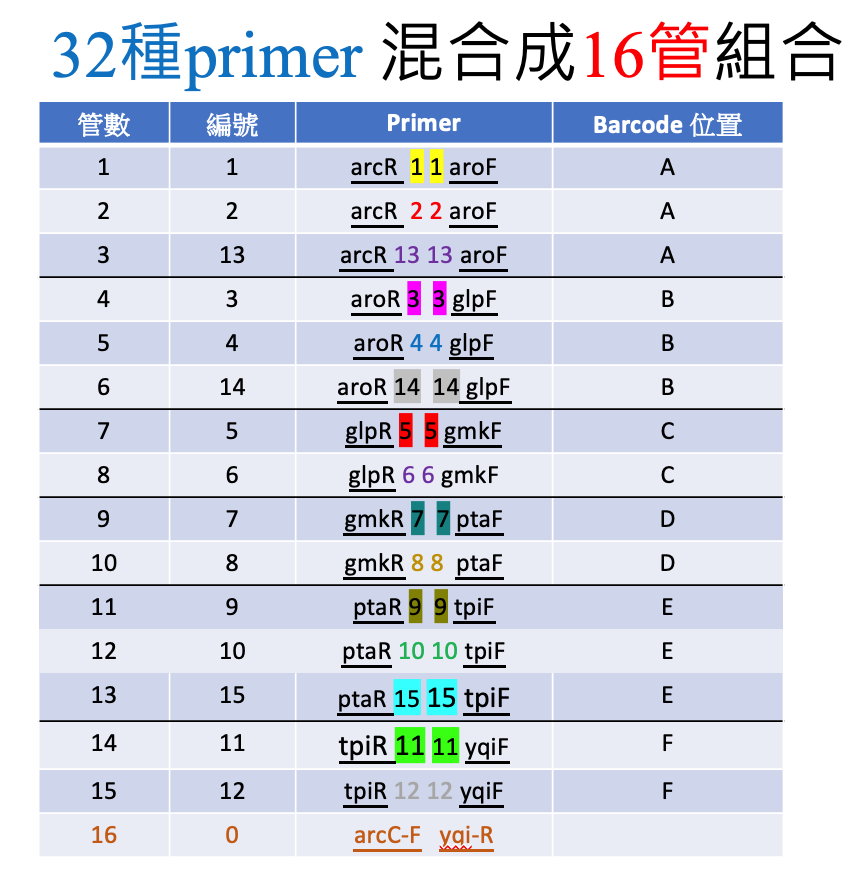

In [57]:
# Reagent volumn assessment and planning
from collections import Counter
calculation = Counter()
for primer_set in primer_list:
    for primer in primer_set:
        calculation[primer]+=1
calculation
# one for 20ul
# arc_F, yqi_R: 32 ul

NameError: name 'primer_list' is not defined

In [36]:
right_pipette.pick_up_tip()
right_pipette.drop_tip()

<InstrumentContext: p20_single_v2.1 in RIGHT>

Exception in Module registration
Traceback (most recent call last):
  File "usr/lib/python3.7/site-packages/opentrons/drivers/utils.py", line 90, in parse_device_information
  File "usr/lib/python3.7/site-packages/opentrons/drivers/utils.py", line 90, in <dictcomp>
KeyError: 'model'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/module_control.py", line 240, in handle_module_appearance
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/module_control.py", line 117, in register_modules
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/module_control.py", line 63, in build_module
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/modules/utils.py", line 37, in build
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/modules/magdeck.py", line 48, in build
  File "usr/lib/python3.7/site-packages/opentro

# Basic Practice On Moving Pipette

In [20]:
left_pipette.blow_out()    

left_pipette.drop_tip()


<InstrumentContext: p300_single_v2.1 in LEFT>

In [19]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300['A1'])

left_pipette.aspirate(25, product_container['A1'])

left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹


left_pipette.dispense(25, primers_container['A1'])
left_pipette.blow_out()    

left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1

TypeError: blow_out() got an unexpected keyword argument 'v_offset'

# Combination of primers set

In [18]:
# primer location in 96-well: mapping primer to its physical well position

primer_location_list = dict({'arc_F':'A1', 
                             '1_arc_R':'B1', 
                             '1_aro_F':'C1',
                             '2_arc_R':'D1',
                             '2_aro_F':'E1',
                             '3_aro_R':'F1',
                             '3_glp_F':'G1',
                             '4_aro_R':'H1',
                             '4_glp_F':'A2',
                             '5_glp_R':'B2',
                             '5_gmk_F':'C2',
                             '7_gmk_R':'D2',
                             '7_pta_F':'E2',
                             '9_pta_R':'F2',
                             '9_tpi_F':'G2',
                             '10_pta_R':'H2',
                             '10_tpi_F':'A3',
                             '11_tpi_R':'B3',
                             '11_yqi_F':'C3',
                             '12_tpi_R':'D3',
                             '12_yqi_F':'E3',
                             'yqi_R':'F3'})

put_50_wells_1 = ["A1","D1","E1","F1", "G1", "B2"] # 300
put_50_wells_2 = ["E2","H2","A3","B3", "C3", "F3"] # 300
put_25_wells = ["B1","C1","H1","A2","C2","D2","F2","G2","D3","E3"] #250

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹

# section 1 =============================
left_pipette.pick_up_tip(tips_300['A1'])
left_pipette.aspirate(300, product_container['A1'])


## draw multiple wells at one time
for well in put_50_wells_1:
    left_pipette.dispense(50, primers_container[well])

left_pipette.blow_out(v_offset=3)    
left_pipette.drop_tip()

# section 2 =============================
left_pipette.pick_up_tip(tips_300['B1'])
left_pipette.aspirate(300, product_container['B1'])


## draw multiple wells at one time
for well in put_50_wells_2:
    left_pipette.dispense(50, primers_container[well])
    
left_pipette.blow_out()    
left_pipette.drop_tip()

# section 3 =============================
left_pipette.pick_up_tip(tips_300['C1'])
left_pipette.aspirate(250, product_container['C1'])

## draw multiple wells at one time
for well in put_25_wells:
    left_pipette.dispense(25, primers_container[well])

left_pipette.blow_out()    
left_pipette.drop_tip()


left_pipette.well_bottom_clearance.dispense = 1

In [50]:
primer_location_list = dict({'arc_F':'A1', 
                             '1_arc_R':'B1', 
                             '2_arc_R':'C1',
                             '1_aro_F':'D1',
                             '2_aro_F':'E1',
                             '3_aro_R':'F1',
                             '4_aro_R':'G1',
                             '3_glp_F':'H1',
                             '4_glp_F':'A2',
                             '5_glp_R':'B2',
                             '5_gmk_F':'C2',
                             '7_gmk_R':'D2',
                             '7_pta_F':'E2',
                             '9_pta_R':'F2',
                             '10_pta_R':'G2',
                             '9_tpi_F':'H2',
                             '10_tpi_F':'A3',
                             '11_tpi_R':'B3',
                             '12_tpi_R':'C3',
                             '11_yqi_F':'D3',
                             '12_yqi_F':'E3',
                             'yqi_R':'F3'})

primer_product_list = dict({'1A':'A10',
                            '1B':'B10',
                            '2A':'C10',
                            '2B':'D10',
                            '2C':'E10',
                            '2D':'F10',
                            '3A':'G10',
                            '3B':'H10',
                            '4A':'A11',
                            '5A':'B11',
                            '5B':'C11',
                            '6A':'D11',
                            '6B':'E11',
                            '6C':'F11',
                            '6D':'G11',
                            '7A':'H11',
                            '7B':'A12'})

primer_set_list = dict({'1A':['arc_F', '1_arc_R'],
                        '1B':['arc_F', '2_arc_R'],
                            '2A':['1_aro_F','3_aro_R'],
                            '2B':['2_aro_F','3_aro_R'],
                            '2C':['1_aro_F','4_aro_R'],
                            '2D':['2_aro_F','4_aro_R'],
                            '3A':['3_glp_F','5_glp_R'],
                            '3B':['4_glp_F','5_glp_R'],
                            '4A':['5_gmk_F','7_gmk_R'],
                            '5A':['7_pta_F','9_pta_R'],
                            '5B':['7_pta_F','10_pta_R'],
                            '6A':['9_tpi_F','11_tpi_R'],
                            '6B':['10_tpi_F','11_tpi_R'],
                            '6C':['9_tpi_F','12_tpi_R'],
                            '6D':['10_tpi_F','12_tpi_R'],
                            '7A':['11_yqi_F','yqi_R'],
                            '7B':['12_yqi_F','yqi_R']})



In [52]:
left_pipette.flow_rate.aspirate = 15  # speed too quick
left_pipette.flow_rate.dispense = 15
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well
for item_set in primer_set_list:
    print("set item: ",item_set,"test")
    for primer in primer_set_list[item_set]:
        primer_locate = primer_location_list[primer]
        destination = primer_product_list[item_set]
        print(primer_locate)
        print(destination)
        
        left_pipette.pick_up_tip()
        left_pipette.aspirate(25, primers_container[primer_locate])
        left_pipette.dispense(25, primers_container[destination])
        #left_pipette.blow_out()    
        left_pipette.drop_tip()

set item:  1A test
A1
A10
B1
A10
set item:  1B test
A1
B10
C1
B10
set item:  2A test
D1
C10
F1
C10
set item:  2B test
E1
D10
F1
D10
set item:  2C test
D1
E10
G1
E10
set item:  2D test
E1
F10
G1
F10
set item:  3A test
H1
G10
B2
G10
set item:  3B test
A2
H10
B2
H10
set item:  4A test
C2
A11
D2
A11
set item:  5A test
E2
B11
F2
B11
set item:  5B test
E2
C11
G2
C11
set item:  6A test
H2
D11
B3
D11
set item:  6B test
A3
E11
B3
E11
set item:  6C test
H2
F11
C3
F11
set item:  6D test
A3
G11
C3
G11
set item:  7A test
D3
H11
F3
H11
set item:  7B test
E3
A12
F3
A12


In [ ]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹

# section 1 =============================

## draw multiple wells at one time
for primer_set in put_50_wells_1:
    left_pipette.pick_up_tip()
    left_pipette.aspirate(300, product_container['A1'])
    left_pipette.dispense(50, primers_container[well])

left_pipette.blow_out(v_offset=3)    
left_pipette.drop_tip()


# single move function for each primer

In [ ]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300['A1'])
left_pipette.aspirate(25, dye_container['B1'])
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹
left_pipette.dispense(35, A_plate['A2'])
left_pipette.dispense(35, A_plate['B2'])
left_pipette.dispense(35, A_plate['C2'])
left_pipette.dispense(35, A_plate['D2'])
left_pipette.dispense(35, A_plate['E2'])
left_pipette.dispense(35, A_plate['F2'])
left_pipette.dispense(35, A_plate['G2'])
left_pipette.dispense(35, A_plate['H2'])
left_pipette.drop_tip()
left_pipette.well_bottom_clearance.dispense = 1

# Test p300 and multiple dispense

In [15]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300['A1'])
left_pipette.aspirate(30, product_container['A1'])
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹
left_pipette.dispense(35, A_plate['A2'])
left_pipette.drop_tip()
left_pipette.well_bottom_clearance.dispense = 1

# Test p20 and multiple dispense

In [18]:
right_pipette.flow_rate.aspirate  = 2
right_pipette.flow_rate.dispense  = 2
right_pipette.pick_up_tip(tips_10['C1'])
right_pipette.well_bottom_clearance.aspirate = 1.1 # 這高度就算可以惹
right_pipette.well_bottom_clearance.dispense = 1.2 # 這高度就算可以惹
right_pipette.aspirate(10, A_plate['C2'])
right_pipette.dispense(1, B_plate['B4'])
right_pipette.dispense(1, B_plate['C4'])
right_pipette.dispense(1, B_plate['D4'])
right_pipette.dispense(1, B_plate['E4'])
right_pipette.dispense(1, B_plate['F4'])
right_pipette.dispense(1, B_plate['G4'])
right_pipette.dispense(1, B_plate['H4'])
right_pipette.drop_tip()
right_pipette.well_bottom_clearance.dispense = 1

Pause with message: /dev/ot_module_thermocycler0: No response to 'M141 
'


# Protocol

##  pipete setting
for p300
aspirate at the default flowraet of 150 uL/s
dispense at the default flowrate of 300 ul/s
fof p20
aspiration, dispense default flowrate: 3.78 ul/s, range 0.1 - 20

In [7]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

In [34]:
left_pipette.pick_up_tip(tips_300['A1']) # pick tips
left_pipette.aspirate(100, dye_container['D1']) # pick Red
left_pipette.dispense(100, B_plate['A1']) # draw 
left_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.6703677749266 deck) too high for limit 418.0


<InstrumentContext: p300_single_v2.1 in LEFT>

In [7]:
# draw function
def draw_at(tip_location, draw_position, color_pos):
    left_pipette.pick_up_tip(tips[tip_location]) # pick tips
    left_pipette.aspirate(50, dye_container[color_pos]) # pick Red
    left_pipette.dispense(50, test_plate[draw_position]) # draw 
    left_pipette.blow_out()
    left_pipette.drop_tip()

In [8]:
draw_at(tip_location="A3", draw_position="A3", color_pos="A1")

## Practice 01:Draw a "line" program

In [17]:
blue_wells = ["G2","F3","E4","D5"]

## pick up tips 
left_pipette.pick_up_tip(tips["A2"])

## pick up color reagent
left_pipette.aspirate(200, dye_container["A1"])

## draw multiple wells at one time

for well in blue_wells:
    left_pipette.dispense(50, test_plate[well])

# finish and drop tips    
left_pipette.blow_out()
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

## Practice 02: Draw complex figure

In [18]:
green_wells = ["F5","G6"]

## pick up tips 
left_pipette.pick_up_tip(tips["A3"])

## pick up color reagent
left_pipette.aspirate(100, dye_container["D1"])

## draw multiple wells at one time

for well in green_wells:
    left_pipette.dispense(50, test_plate[well])

# finish and drop tips    
left_pipette.blow_out()
left_pipette.drop_tip()


red_wells = ["H5","F7","E8","D9","C10","D11", "E12"]

## pick up tips 
left_pipette.pick_up_tip(tips["A4"])

## pick up color reagent
left_pipette.aspirate(280, dye_container["C1"])

## draw multiple wells at one time

for well in red_wells:
    left_pipette.dispense(40, test_plate[well])

# finish and drop tips    
left_pipette.blow_out()
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

## Practice 03: use two loop to draw

In [11]:
blue_wells = ["A4","B3","B4","B5","D4"]
yellow_wells = ["D1","D2","C2","E2"]
red_wells = ["F3","F4","F5","G4","D4"]
green_wells = ["D6","D7","C6","E6"]

all_color_list = [blue_wells, yellow_wells, red_wells, green_wells]

tips_position = ["B1", "B2", "B3", "B4"]
color_position = ["A1", "B1", "C1", "D1"]
each_round_volumn = [250, 240, 250, 200]
dispense_volum = [50, 60, 50, 50]


for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(dispense_volum[i], test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()

## Practice 2: draw a "A"
simplifier

In [33]:
blue_wells = ["A5"]
red_wells = ["B4","C3","D2","E2","F2","G2"]
yellow_wells = ["B6","C7","D8","E8","F8","G8"]
green_wells = ["E3","E4","E5","E6","E7"]
all_color_list = [blue_wells, red_wells, yellow_wells, green_wells]
tips_position = ["A1", "A2", "A3", "A4"]
color_position = ["A1", "C1", "B1", "D1"]
each_round_volumn = [50, 300, 300, 250]



for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(50, test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()

## Practice 3: draw a "Love"

In [29]:
blue_wells = ["D2", "E2", "F2", "F3", "F4"]
red_wells = ["D5","E5","F5","D6","D7","E7", "F7", "F6"]
yellow_wells = ["D8","E8","F9","E10","D10"]
green_wells = ["C11","C12","D11","E11","E12", "F11", "G11", "G12"]
all_color_list = [blue_wells, red_wells, yellow_wells, green_wells]
tips_position = ["B1", "B2", "B3", "B4"]
color_position = ["A1", "C1", "B1", "D1"]
each_round_volumn = [250, 280, 250, 280]
dispense_volum = [50, 35, 50, 35]


for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(dispense_volum[i], test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.6703677749266 deck) too high for limit 418.0


# Practice 4: draw a "OK"

In [24]:
blue_wells = ["B2", "C2", "D2", "F2", "G2"]
red_wells = ["B3","B4","C4","D4","E4","F4", "G4", "G3"]
yellow_wells = ["B6","C6","D6","E6","F6", "G6"]
green_wells = ["B9", "C8", "D7", "E7", "F8", "G9"]
all_color_list = [blue_wells, red_wells, yellow_wells, green_wells]
tips_position = ["A2", "A3", "A4", "A5"]
color_position = ["A1", "C1", "B1", "D1"]
each_round_volumn = [250, 280, 240, 240]
dispense_volum = [50, 35, 40, 40]


for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(dispense_volum[i], test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()